In [30]:
%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [31]:
%%jinja markdown
Shape Technical Report

Shape Technical Report

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency
from collections import Counter
from utils import *
import pywt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import shap
import io

In [4]:
%%jinja markdown
# Introduction

The development of predictive models for the maintenance of FPSO vessel equipment represents a pivotal advancement 
in the maritime and oil & gas industries, promising to revolutionize how these sectors approach maintenance management 
and operational efficiency. By leveraging historical data and advanced analytics, predictive models enable stakeholders 
to anticipate equipment failures before they occur, facilitating timely maintenance actions that can significantly 
reduce downtime and associated costs. This proactive approach not only enhances the reliability and safety of FPSO 
operations but also optimizes the lifecycle of critical equipment, ensuring that maintenance resources are allocated 
more effectively. In an industry where operational interruptions can lead to substantial financial losses and environmental 
risks, the ability to predict and mitigate potential failures through advanced modeling techniques is invaluable, driving 
improvements in operational resilience, cost-efficiency, and environmental stewardship.

To enable the operations of an FPSO, sensors are used to make sure the equipment does not fail. 
These sensors measure different parameters of the equipment in different setup configurations (preset 1 and preset 2) over time. 

## Objectives

The primary goal of this study is to conduct a comprehensive analysis of failures in 
FPSO vessels to derive actionable insights that will inform the optimal timing of maintenance interventions. 

To achieve this overarching goal, we have identified the following specific objectives:

1. **Assess Data Quality:** Examine the database to evaluate the integrity and quality of the data on FPSO vessel failures.
2. **Quantify Equipment Failures:** Calculate the frequency of equipment failures to understand their prevalence and impact.
3. **Analyze Failure Correlations:** Investigate the relationship between preset conditions and the occurrences of failures, identifying any significant patterns.
4. **Determine Parameter Influence:** Analyze how each parameter contributes to equipment failures, highlighting critical factors.
5. **Develop a Predictive Model:** Construct a model capable of predicting equipment failures based on analyzed variables, enhancing preemptive maintenance strategies.
6. **Evaluate Variable Significance:** Assess the importance of each variable within the predictive model to understand their impact on failure prediction accuracy.



# Introduction

The development of predictive models for the maintenance of FPSO vessel equipment represents a pivotal advancement 
in the maritime and oil & gas industries, promising to revolutionize how these sectors approach maintenance management 
and operational efficiency. By leveraging historical data and advanced analytics, predictive models enable stakeholders 
to anticipate equipment failures before they occur, facilitating timely maintenance actions that can significantly 
reduce downtime and associated costs. This proactive approach not only enhances the reliability and safety of FPSO 
operations but also optimizes the lifecycle of critical equipment, ensuring that maintenance resources are allocated 
more effectively. In an industry where operational interruptions can lead to substantial financial losses and environmental 
risks, the ability to predict and mitigate potential failures through advanced modeling techniques is invaluable, driving 
improvements in operational resilience, cost-efficiency, and environmental stewardship.

To enable the operations of an FPSO, sensors are used to make sure the equipment does not fail. 
These sensors measure different parameters of the equipment in different setup configurations (preset 1 and preset 2) over time. 

## Objectives

The primary goal of this study is to conduct a comprehensive analysis of failures in 
FPSO vessels to derive actionable insights that will inform the optimal timing of maintenance interventions. 

To achieve this overarching goal, we have identified the following specific objectives:

1. **Assess Data Quality:** Examine the database to evaluate the integrity and quality of the data on FPSO vessel failures.
2. **Quantify Equipment Failures:** Calculate the frequency of equipment failures to understand their prevalence and impact.
3. **Analyze Failure Correlations:** Investigate the relationship between preset conditions and the occurrences of failures, identifying any significant patterns.
4. **Determine Parameter Influence:** Analyze how each parameter contributes to equipment failures, highlighting critical factors.
5. **Develop a Predictive Model:** Construct a model capable of predicting equipment failures based on analyzed variables, enhancing preemptive maintenance strategies.
6. **Evaluate Variable Significance:** Assess the importance of each variable within the predictive model to understand their impact on failure prediction accuracy.

In [5]:
filename = "./O_G_Equipment_Data.xlsx"
data = pd.read_excel(filename)
buf = io.StringIO()
data.info(buf=buf)
s = buf.getvalue()
lines = [line.split() for line in s.splitlines()[3:-2]]
info_df = pd.DataFrame(lines)

In [6]:
%%jinja markdown

# Methodology

## Dataset

We have data from a a sensor installed in equipment onboard a FPSO vessel. The sensors measures the Temperature, Pressure, Vibration in X, Y and Z direction, and Frequency of
of a certain phenomena important to their operation, as we can see in the dataset first rows presented in the Table 1 bellow.

<div id="my_table">
<summary>Table 1: Dataset</summary>
{{ data.head().to_html() }}
</div>

The data set consists in 10 columns, with  800 non-null measurements, structured as it follows:
    
* **Cycle:** Represents the operation cycle number of the equipment. This column serve as a temporal or sequential index, indicating the order in which the operation cycles were recorded.

* **Preset_1** and **Preset_2:** These columns are predefined settings or parameters applied to the equipment before or during each operation cycle. The values in these columns might represent different modes of operation, configuration adjustments, or other parameters relevant to the equipment's functioning.

* **Temperature:** Records the temperature of the equipment or the environment in which the equipment is operating during the cycle. Temperature can be a critical factor affecting the equipment's performance and safety.

* **Pressure:** Similarly, this column indicates the pressure measured during the operation cycle. Pressure is another vital parameter that can influence the efficacy and safety of equipment operations.

* **VibrationX, VibrationY, VibrationZ:** These columns measure the equipment's vibrations in three orthogonal directions (X, Y, Z). Excessive vibrations can be indicative of impending equipment problems or failures, making these measurements important for predictive maintenance and failure prevention.

* **Frequency:** Related to the frequency of vibrations or some other periodic operational measure of the equipment. 

* **Fail:** A boolean column (True/False) indicating whether a failure occurred in the equipment during the cycle. This column is essential for reliability analyses and developing predictive models of failures.

The description and information of the data are in Tables 2, and 3.

<details>
<summary>Table 2: Data Description</summary>

{{ data.describe().to_html()  }}
</details>


<details>
<summary>Table 3: Information</summary>

{{ info_df.to_html()  }}
</details>

The exploratory analysis will be done to gain insights about the datase and to assess potential dependencies present in the data. This will be done mailly by varius techniques and visualization
to understant the data distribution, characteristics and relationshipt between the parameters. 

The last part will be the modeling and prediction. For this work we will use a set of classifiers models, using logistic regression, and decision trees to predict wheter or not the equipment 
has failed.

The model will be evaluated by the accuracy and reccall. Accuracy can be a good measurementy for balanced dataset, but it has problems with unbalancedondes. The recall is a 
way to measure how good the model is doing with false positives. Having a higher recall means when in doubt, the model would predict the equipment is 
failing so we don’t risk missing fixing the equipment that actually is failing. This way, we’re more likely to correctly identify more failures.

# Exploratory analysis


# Methodology

## Dataset

We have data from a a sensor installed in equipment onboard a FPSO vessel. The sensors measures the Temperature, Pressure, Vibration in X, Y and Z direction, and Frequency of
of a certain phenomena important to their operation, as we can see in the dataset first rows presented in the Table 1 bellow.

<div id="my_table">
<summary>Table 1: Dataset</summary>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Cycle</th>
      <th>Preset_1</th>
      <th>Preset_2</th>
      <th>Temperature</th>
      <th>Pressure</th>
      <th>VibrationX</th>
      <th>VibrationY</th>
      <th>VibrationZ</th>
      <th>Frequency</th>
      <th>Fail</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>3</td>
      <td>6</td>
      <td>44.235186</td>
      <td>47.657254</td>
      <td>46.441769</td>
      <td>64.820327</td>
      <td>66.454520</td>
      <td>44.483250</td>
      <td>False</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>2</td>
      <td>4</td>
      <td>60.807234</td>
      <td>63.172076</td>
      <td>62.005951</td>
      <td>80.714431</td>
      <td>81.246405</td>
      <td>60.228715</td>
      <td>False</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3</td>
      <td>2</td>
      <td>1</td>
      <td>79.027536</td>
      <td>83.032190</td>
      <td>82.642110</td>
      <td>98.254386</td>
      <td>98.785196</td>
      <td>80.993479</td>
      <td>False</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>2</td>
      <td>3</td>
      <td>79.716242</td>
      <td>100.508634</td>
      <td>122.362321</td>
      <td>121.363429</td>
      <td>118.652538</td>
      <td>80.315567</td>
      <td>False</td>
    </tr>
    <tr>
      <th>4</th>
      <td>5</td>
      <td>2</td>
      <td>5</td>
      <td>39.989054</td>
      <td>51.764833</td>
      <td>42.514302</td>
      <td>61.037910</td>
      <td>50.716469</td>
      <td>64.245166</td>
      <td>False</td>
    </tr>
  </tbody>
</table>
</div>

The data set consists in 10 columns, with  800 non-null measurements, structured as it follows:
    
* **Cycle:** Represents the operation cycle number of the equipment. This column serve as a temporal or sequential index, indicating the order in which the operation cycles were recorded.

* **Preset_1** and **Preset_2:** These columns are predefined settings or parameters applied to the equipment before or during each operation cycle. The values in these columns might represent different modes of operation, configuration adjustments, or other parameters relevant to the equipment's functioning.

* **Temperature:** Records the temperature of the equipment or the environment in which the equipment is operating during the cycle. Temperature can be a critical factor affecting the equipment's performance and safety.

* **Pressure:** Similarly, this column indicates the pressure measured during the operation cycle. Pressure is another vital parameter that can influence the efficacy and safety of equipment operations.

* **VibrationX, VibrationY, VibrationZ:** These columns measure the equipment's vibrations in three orthogonal directions (X, Y, Z). Excessive vibrations can be indicative of impending equipment problems or failures, making these measurements important for predictive maintenance and failure prevention.

* **Frequency:** Related to the frequency of vibrations or some other periodic operational measure of the equipment. 

* **Fail:** A boolean column (True/False) indicating whether a failure occurred in the equipment during the cycle. This column is essential for reliability analyses and developing predictive models of failures.

The description and information of the data are in Tables 2, and 3.

<details>
<summary>Table 2: Data Description</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Cycle</th>
      <th>Preset_1</th>
      <th>Preset_2</th>
      <th>Temperature</th>
      <th>Pressure</th>
      <th>VibrationX</th>
      <th>VibrationY</th>
      <th>VibrationZ</th>
      <th>Frequency</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>800.0000</td>
      <td>800.000000</td>
      <td>800.000000</td>
      <td>800.000000</td>
      <td>800.000000</td>
      <td>800.000000</td>
      <td>800.000000</td>
      <td>800.000000</td>
      <td>800.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>400.5000</td>
      <td>1.988750</td>
      <td>4.551250</td>
      <td>69.263494</td>
      <td>78.997945</td>
      <td>73.860275</td>
      <td>72.786878</td>
      <td>71.866211</td>
      <td>68.223449</td>
    </tr>
    <tr>
      <th>std</th>
      <td>231.0844</td>
      <td>0.805875</td>
      <td>2.293239</td>
      <td>25.536252</td>
      <td>32.501834</td>
      <td>31.229631</td>
      <td>32.739745</td>
      <td>27.844616</td>
      <td>29.138702</td>
    </tr>
    <tr>
      <th>min</th>
      <td>1.0000</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>2.089354</td>
      <td>3.480279</td>
      <td>3.846343</td>
      <td>10.057744</td>
      <td>18.784169</td>
      <td>4.380101</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>200.7500</td>
      <td>1.000000</td>
      <td>3.000000</td>
      <td>51.040134</td>
      <td>55.508564</td>
      <td>50.752461</td>
      <td>48.523982</td>
      <td>50.787638</td>
      <td>45.861762</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>400.5000</td>
      <td>2.000000</td>
      <td>5.000000</td>
      <td>65.906716</td>
      <td>75.014848</td>
      <td>69.394953</td>
      <td>65.504770</td>
      <td>69.319237</td>
      <td>65.664252</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>600.2500</td>
      <td>3.000000</td>
      <td>7.000000</td>
      <td>80.527220</td>
      <td>99.302530</td>
      <td>90.195059</td>
      <td>94.075572</td>
      <td>88.891205</td>
      <td>90.097457</td>
    </tr>
    <tr>
      <th>max</th>
      <td>800.0000</td>
      <td>3.000000</td>
      <td>8.000000</td>
      <td>255.607829</td>
      <td>189.995681</td>
      <td>230.861142</td>
      <td>193.569947</td>
      <td>230.951134</td>
      <td>178.090303</td>
    </tr>
  </tbody>
</table>
</details>


<details>
<summary>Table 3: Information</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>0</th>
      <th>1</th>
      <th>2</th>
      <th>3</th>
      <th>4</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>#</td>
      <td>Column</td>
      <td>Non-Null</td>
      <td>Count</td>
      <td>Dtype</td>
    </tr>
    <tr>
      <th>1</th>
      <td>---</td>
      <td>------</td>
      <td>--------------</td>
      <td>-----</td>
      <td>None</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0</td>
      <td>Cycle</td>
      <td>800</td>
      <td>non-null</td>
      <td>int64</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1</td>
      <td>Preset_1</td>
      <td>800</td>
      <td>non-null</td>
      <td>int64</td>
    </tr>
    <tr>
      <th>4</th>
      <td>2</td>
      <td>Preset_2</td>
      <td>800</td>
      <td>non-null</td>
      <td>int64</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>Temperature</td>
      <td>800</td>
      <td>non-null</td>
      <td>float64</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>Pressure</td>
      <td>800</td>
      <td>non-null</td>
      <td>float64</td>
    </tr>
    <tr>
      <th>7</th>
      <td>5</td>
      <td>VibrationX</td>
      <td>800</td>
      <td>non-null</td>
      <td>float64</td>
    </tr>
    <tr>
      <th>8</th>
      <td>6</td>
      <td>VibrationY</td>
      <td>800</td>
      <td>non-null</td>
      <td>float64</td>
    </tr>
    <tr>
      <th>9</th>
      <td>7</td>
      <td>VibrationZ</td>
      <td>800</td>
      <td>non-null</td>
      <td>float64</td>
    </tr>
    <tr>
      <th>10</th>
      <td>8</td>
      <td>Frequency</td>
      <td>800</td>
      <td>non-null</td>
      <td>float64</td>
    </tr>
    <tr>
      <th>11</th>
      <td>9</td>
      <td>Fail</td>
      <td>800</td>
      <td>non-null</td>
      <td>bool</td>
    </tr>
  </tbody>
</table>
</details>

The exploratory analysis will be done to gain insights about the datase and to assess potential dependencies present in the data. This will be done mailly by varius techniques and visualization
to understant the data distribution, characteristics and relationshipt between the parameters. 

The last part will be the modeling and prediction. For this work we will use a set of classifiers models, using logistic regression, and decision trees to predict wheter or not the equipment 
has failed.

The model will be evaluated by the accuracy and reccall. Accuracy can be a good measurementy for balanced dataset, but it has problems with unbalancedondes. The recall is a 
way to measure how good the model is doing with false positives. Having a higher recall means when in doubt, the model would predict the equipment is 
failing so we don’t risk missing fixing the equipment that actually is failing. This way, we’re more likely to correctly identify more failures.

# Exploratory analysis

## How many times the equipment has failed?

The equipment has failed 66 times
The failure rate is 8.25%


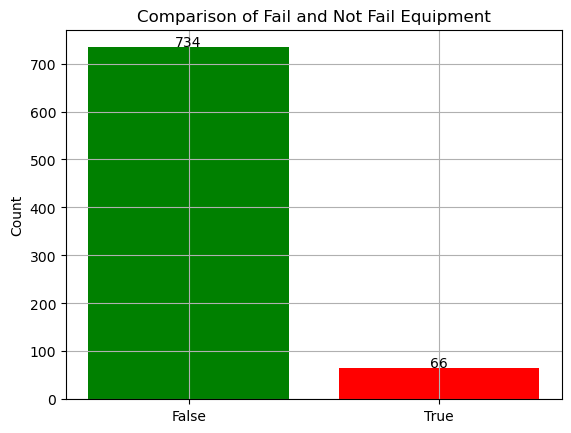

In [7]:
fails_conts = data['Fail'].value_counts()

labels = ['False', 'True']
counts = [fails_conts[False], fails_conts[True]]

fig, ax = plt.subplots()
ax.bar(labels, counts, color=['green', 'red'])

ax.set_ylabel('Count')
ax.set_title('Comparison of Fail and Not Fail Equipment')

for i in range(len(counts)):
    ax.text(i, counts[i] + 1, str(counts[i]), ha='center')
ax.grid()

plt.savefig('fail_not_fail.png', dpi=300 , bbox_inches='tight')

print(f"The equipment has failed {data['Fail'].value_counts().iloc[1]} times")
print(f"The failure rate is {data['Fail'].value_counts().iloc[1]/len(data)*100:.2f}%")

There are $66$ Fails against $734$ normal behaviour in the dataset. It represents $8.25\%$ of the data. From here we can have an idea on how unbalanced the dataset is. This difference can be tricky later on when building the models. Some oversampling technique might be helpfull.

## Categorize failures by Presets

In [8]:
fails_per_preset_1 = data.groupby(['Preset_1', 'Fail']).size().unstack().sort_values(by=True, ascending=False)
fails_per_preset_2 = data.groupby(['Preset_2', 'Fail']).size().unstack().sort_values(by=True, ascending=False)

In [9]:
%%jmd
<div>
<summary>Table 3: Fails per Preset 1</summary>

{{ fails_per_preset_1.to_html()  }}
</div>

<div>
<summary>Table 4: Fails per Preset 2</summary>

{{ fails_per_preset_2.to_html() }}

</div>

<div>
<summary>Table 3: Fails per Preset 1</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Fail</th>
      <th>False</th>
      <th>True</th>
    </tr>
    <tr>
      <th>Preset_1</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>237</td>
      <td>27</td>
    </tr>
    <tr>
      <th>2</th>
      <td>260</td>
      <td>21</td>
    </tr>
    <tr>
      <th>3</th>
      <td>237</td>
      <td>18</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<summary>Table 4: Fails per Preset 2</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Fail</th>
      <th>False</th>
      <th>True</th>
    </tr>
    <tr>
      <th>Preset_2</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>88</td>
      <td>12</td>
    </tr>
    <tr>
      <th>1</th>
      <td>84</td>
      <td>11</td>
    </tr>
    <tr>
      <th>2</th>
      <td>92</td>
      <td>9</td>
    </tr>
    <tr>
      <th>6</th>
      <td>92</td>
      <td>9</td>
    </tr>
    <tr>
      <th>7</th>
      <td>100</td>
      <td>9</td>
    </tr>
    <tr>
      <th>8</th>
      <td>93</td>
      <td>7</td>
    </tr>
    <tr>
      <th>3</th>
      <td>95</td>
      <td>6</td>
    </tr>
    <tr>
      <th>4</th>
      <td>90</td>
      <td>3</td>
    </tr>
  </tbody>
</table>

</div>

In [10]:
%%jinja markdown
Tables 1 and 2 present the number of Fails for the preset$_1$ (left), and preset$_2$ (right). The configuration $1$ in preset$_1$ was the one with more failures; 
and the configuration $5$ was the one with more failures in preset$_2$.


Tables 1 and 2 present the number of Fails for the preset$_1$ (left), and preset$_2$ (right). The configuration $1$ in preset$_1$ was the one with more failures; 
and the configuration $5$ was the one with more failures in preset$_2$.

In [11]:
combination = data.groupby(['Preset_1','Preset_2', 'Fail']).size().unstack(fill_value=0)
combination['Percentage_fail'] = combination[True] / (combination[True] + combination[False]) * 100
combination['cumulative'] = combination[True].cumsum()
combination.reset_index(inplace=True)
combination.reset_index(inplace=True)
combination_sorted =combination.sort_values(by=True, ascending=False)

In [12]:
%%jinja markdown
<div>
<summary>Table 5: Fails per combination of presets</summary>

{{ combination_sorted.to_html() }}

</div>

<div>
<summary>Table 5: Fails per combination of presets</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Fail</th>
      <th>index</th>
      <th>Preset_1</th>
      <th>Preset_2</th>
      <th>False</th>
      <th>True</th>
      <th>Percentage_fail</th>
      <th>cumulative</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>1</td>
      <td>2</td>
      <td>33</td>
      <td>5</td>
      <td>13.157895</td>
      <td>9</td>
    </tr>
    <tr>
      <th>4</th>
      <td>4</td>
      <td>1</td>
      <td>5</td>
      <td>26</td>
      <td>5</td>
      <td>16.129032</td>
      <td>18</td>
    </tr>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>1</td>
      <td>1</td>
      <td>30</td>
      <td>4</td>
      <td>11.764706</td>
      <td>4</td>
    </tr>
    <tr>
      <th>20</th>
      <td>20</td>
      <td>3</td>
      <td>5</td>
      <td>25</td>
      <td>4</td>
      <td>13.793103</td>
      <td>59</td>
    </tr>
    <tr>
      <th>6</th>
      <td>6</td>
      <td>1</td>
      <td>7</td>
      <td>34</td>
      <td>4</td>
      <td>10.526316</td>
      <td>25</td>
    </tr>
    <tr>
      <th>8</th>
      <td>8</td>
      <td>2</td>
      <td>1</td>
      <td>26</td>
      <td>4</td>
      <td>13.333333</td>
      <td>31</td>
    </tr>
    <tr>
      <th>15</th>
      <td>15</td>
      <td>2</td>
      <td>8</td>
      <td>33</td>
      <td>4</td>
      <td>10.810811</td>
      <td>48</td>
    </tr>
    <tr>
      <th>22</th>
      <td>22</td>
      <td>3</td>
      <td>7</td>
      <td>31</td>
      <td>3</td>
      <td>8.823529</td>
      <td>65</td>
    </tr>
    <tr>
      <th>21</th>
      <td>21</td>
      <td>3</td>
      <td>6</td>
      <td>27</td>
      <td>3</td>
      <td>10.000000</td>
      <td>62</td>
    </tr>
    <tr>
      <th>16</th>
      <td>16</td>
      <td>3</td>
      <td>1</td>
      <td>28</td>
      <td>3</td>
      <td>9.677419</td>
      <td>51</td>
    </tr>
    <tr>
      <th>13</th>
      <td>13</td>
      <td>2</td>
      <td>6</td>
      <td>34</td>
      <td>3</td>
      <td>8.108108</td>
      <td>42</td>
    </tr>
    <tr>
      <th>12</th>
      <td>12</td>
      <td>2</td>
      <td>5</td>
      <td>37</td>
      <td>3</td>
      <td>7.500000</td>
      <td>39</td>
    </tr>
    <tr>
      <th>5</th>
      <td>5</td>
      <td>1</td>
      <td>6</td>
      <td>31</td>
      <td>3</td>
      <td>8.823529</td>
      <td>21</td>
    </tr>
    <tr>
      <th>10</th>
      <td>10</td>
      <td>2</td>
      <td>3</td>
      <td>24</td>
      <td>2</td>
      <td>7.692308</td>
      <td>35</td>
    </tr>
    <tr>
      <th>14</th>
      <td>14</td>
      <td>2</td>
      <td>7</td>
      <td>35</td>
      <td>2</td>
      <td>5.405405</td>
      <td>44</td>
    </tr>
    <tr>
      <th>9</th>
      <td>9</td>
      <td>2</td>
      <td>2</td>
      <td>32</td>
      <td>2</td>
      <td>5.882353</td>
      <td>33</td>
    </tr>
    <tr>
      <th>7</th>
      <td>7</td>
      <td>1</td>
      <td>8</td>
      <td>22</td>
      <td>2</td>
      <td>8.333333</td>
      <td>27</td>
    </tr>
    <tr>
      <th>17</th>
      <td>17</td>
      <td>3</td>
      <td>2</td>
      <td>27</td>
      <td>2</td>
      <td>6.896552</td>
      <td>53</td>
    </tr>
    <tr>
      <th>18</th>
      <td>18</td>
      <td>3</td>
      <td>3</td>
      <td>30</td>
      <td>2</td>
      <td>6.250000</td>
      <td>55</td>
    </tr>
    <tr>
      <th>3</th>
      <td>3</td>
      <td>1</td>
      <td>4</td>
      <td>20</td>
      <td>2</td>
      <td>9.090909</td>
      <td>13</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>1</td>
      <td>3</td>
      <td>41</td>
      <td>2</td>
      <td>4.651163</td>
      <td>11</td>
    </tr>
    <tr>
      <th>11</th>
      <td>11</td>
      <td>2</td>
      <td>4</td>
      <td>39</td>
      <td>1</td>
      <td>2.500000</td>
      <td>36</td>
    </tr>
    <tr>
      <th>23</th>
      <td>23</td>
      <td>3</td>
      <td>8</td>
      <td>38</td>
      <td>1</td>
      <td>2.564103</td>
      <td>66</td>
    </tr>
    <tr>
      <th>19</th>
      <td>19</td>
      <td>3</td>
      <td>4</td>
      <td>31</td>
      <td>0</td>
      <td>0.000000</td>
      <td>55</td>
    </tr>
  </tbody>
</table>

</div>

By looking the picture we just can see that the Failues happens during all the period, and the cumulative sum of failues increases over time. The cummulative curve is pratically linear. Although the curve is well lienarly fitted, not showing clear relation bewteen the presets and the failures, we can observe that around the combination 20, 11, 4,and 23, there is a little drop relatively to the curve. This could indicate that those presets could be countrinuing to a reduction in the cummulative sum. In other words, those combinations can have lower counts of failures.

We can see by looking the table that the combination of presets 3 and 4, had no failures. Also, the percentages of failues for 3-8 and 2-4 were the lowest. 

## Distribution of values

One way to evaluate the contribution of each variable in equipment failure is the distribution of its intensity. The Figure below show the distribution for each of the variables.

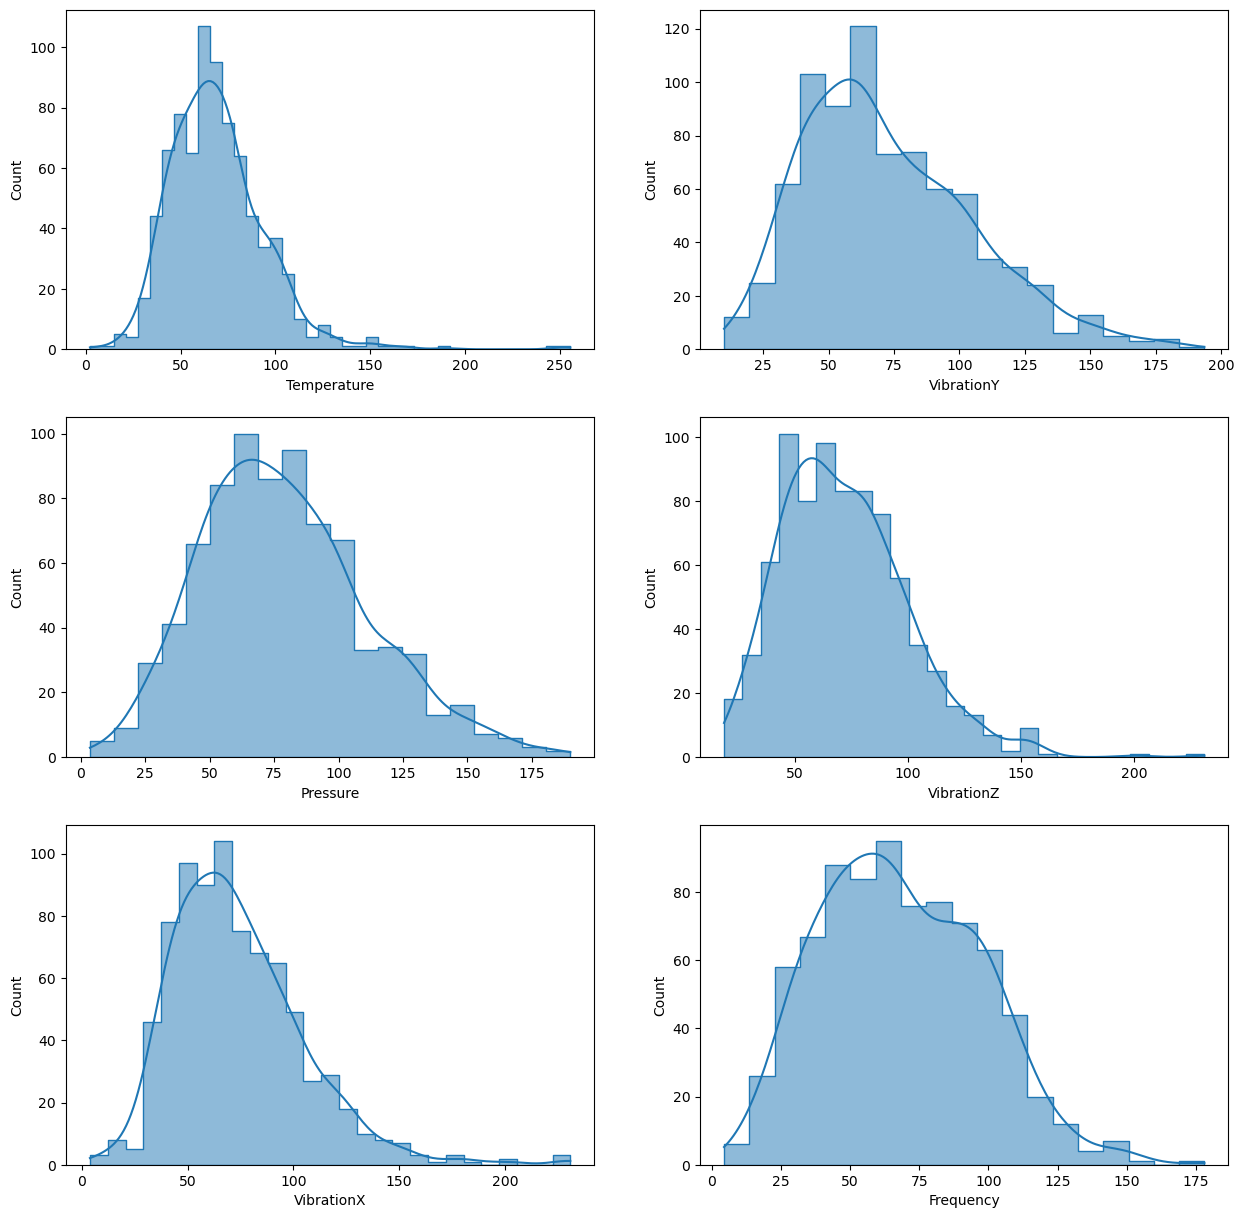

In [13]:
parameters = ['Temperature', 'Pressure','VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
axs = ax.T.flatten()
for axx in range(len(axs)):
    g = sns.histplot(data, x=parameters[axx], kde=True, element='step', legend=True, ax=axs[axx], common_norm=False)
    leg = g.axes.get_legend()
    axs[axx].set_xlabel(parameters[axx])
    axs[axx].set_ylabel('Count')
    new_title = 'Fail'
plt.savefig('histograms.png', dpi=300, bbox_inches='tight')

The Figure show the distribution of variables measurementes. All the sensors, expect the VibrationX, present a shape more like a bimodal distribution. It can be realated to a subgroup of values. Splitting the data in Failure and not Failure can give us a better understanding.

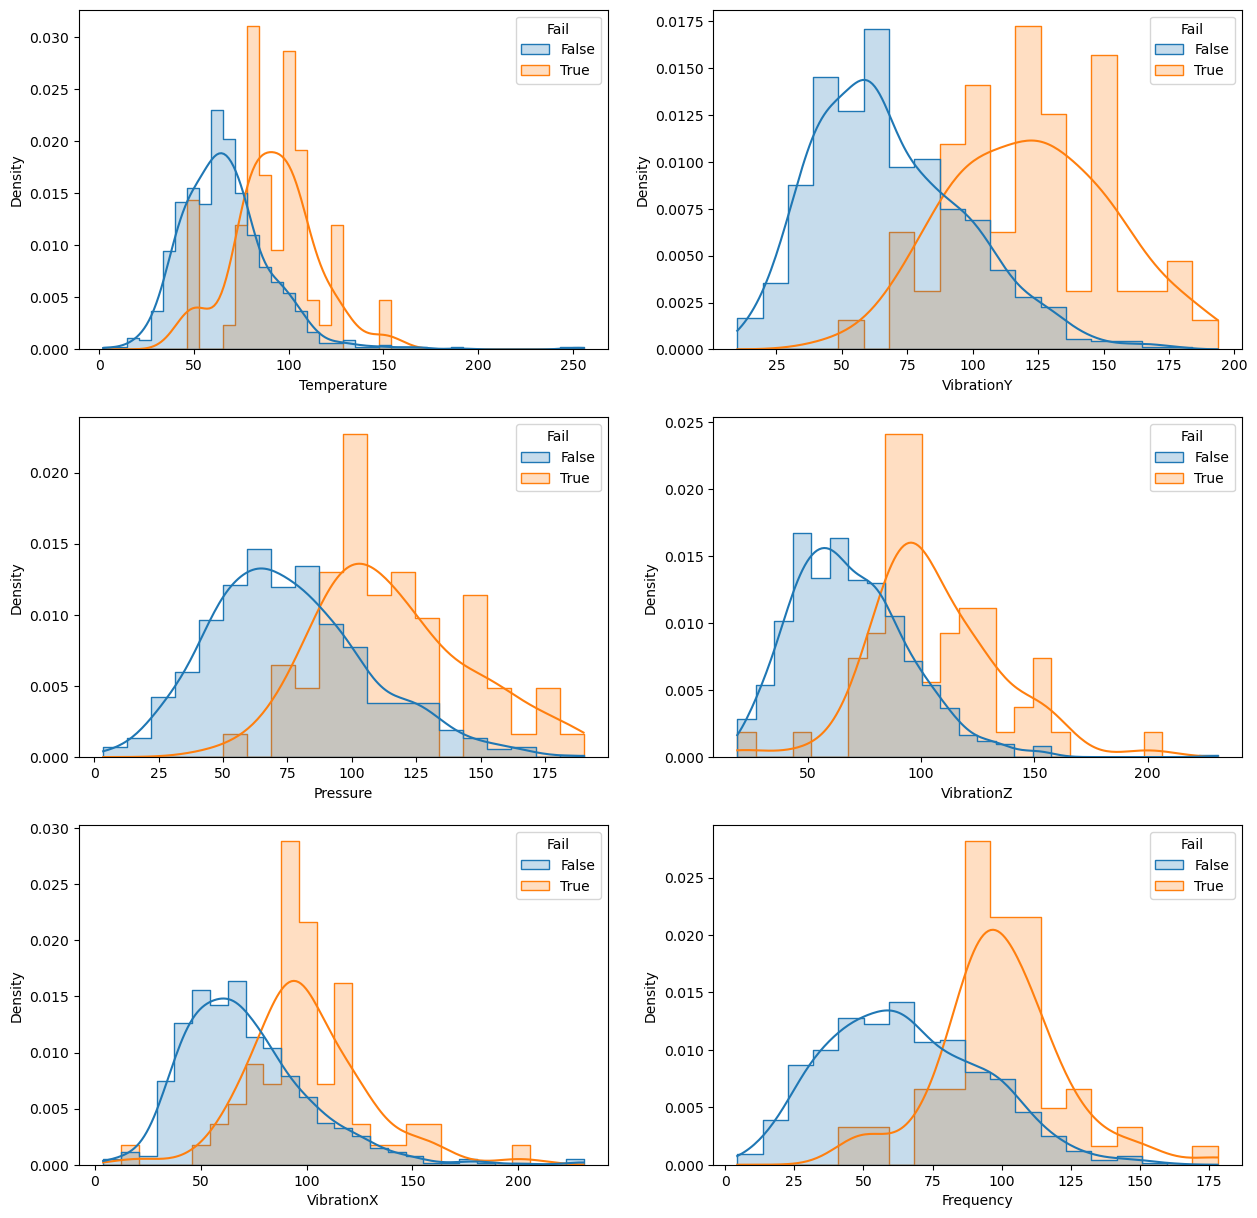

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

axs = ax.T.flatten()

for axx in range(len(axs)):
    g = sns.histplot(data, x=parameters[axx], hue='Fail', kde=True, element='step', legend=True,stat='density', ax=axs[axx], common_norm=False)
    leg = g.axes.get_legend()
    axs[axx].set_xlabel(parameters[axx])
    axs[axx].set_ylabel('Density')
    new_title = 'Fail'
    leg.set_title(new_title)
    new_labels = ['False', 'True']
    for t, l in zip(leg.texts, new_labels):
        t.set_text(l)

plt.savefig('histograms_separated.png', dpi=300, bbox_inches='tight')

The distributions in the Figure above shows a clear separation in the Failures and not Failure measurements. We can see that the measurements have higher values when the failures happens. The VibrationZ, VibrationY, and Pressure were the ones that also have a tail with larger values. 

### Time series analysis

Here we investigate if there is a prefferencial cycle or moment of the fail occurs. It offers another view on what is happening to the intensity of the parameters 
when the fail occur. A time-frequency analysies will be applied as well using Continuous Wavelet trasform in order to attempt to identyfy changes in frequency
during the cycles.


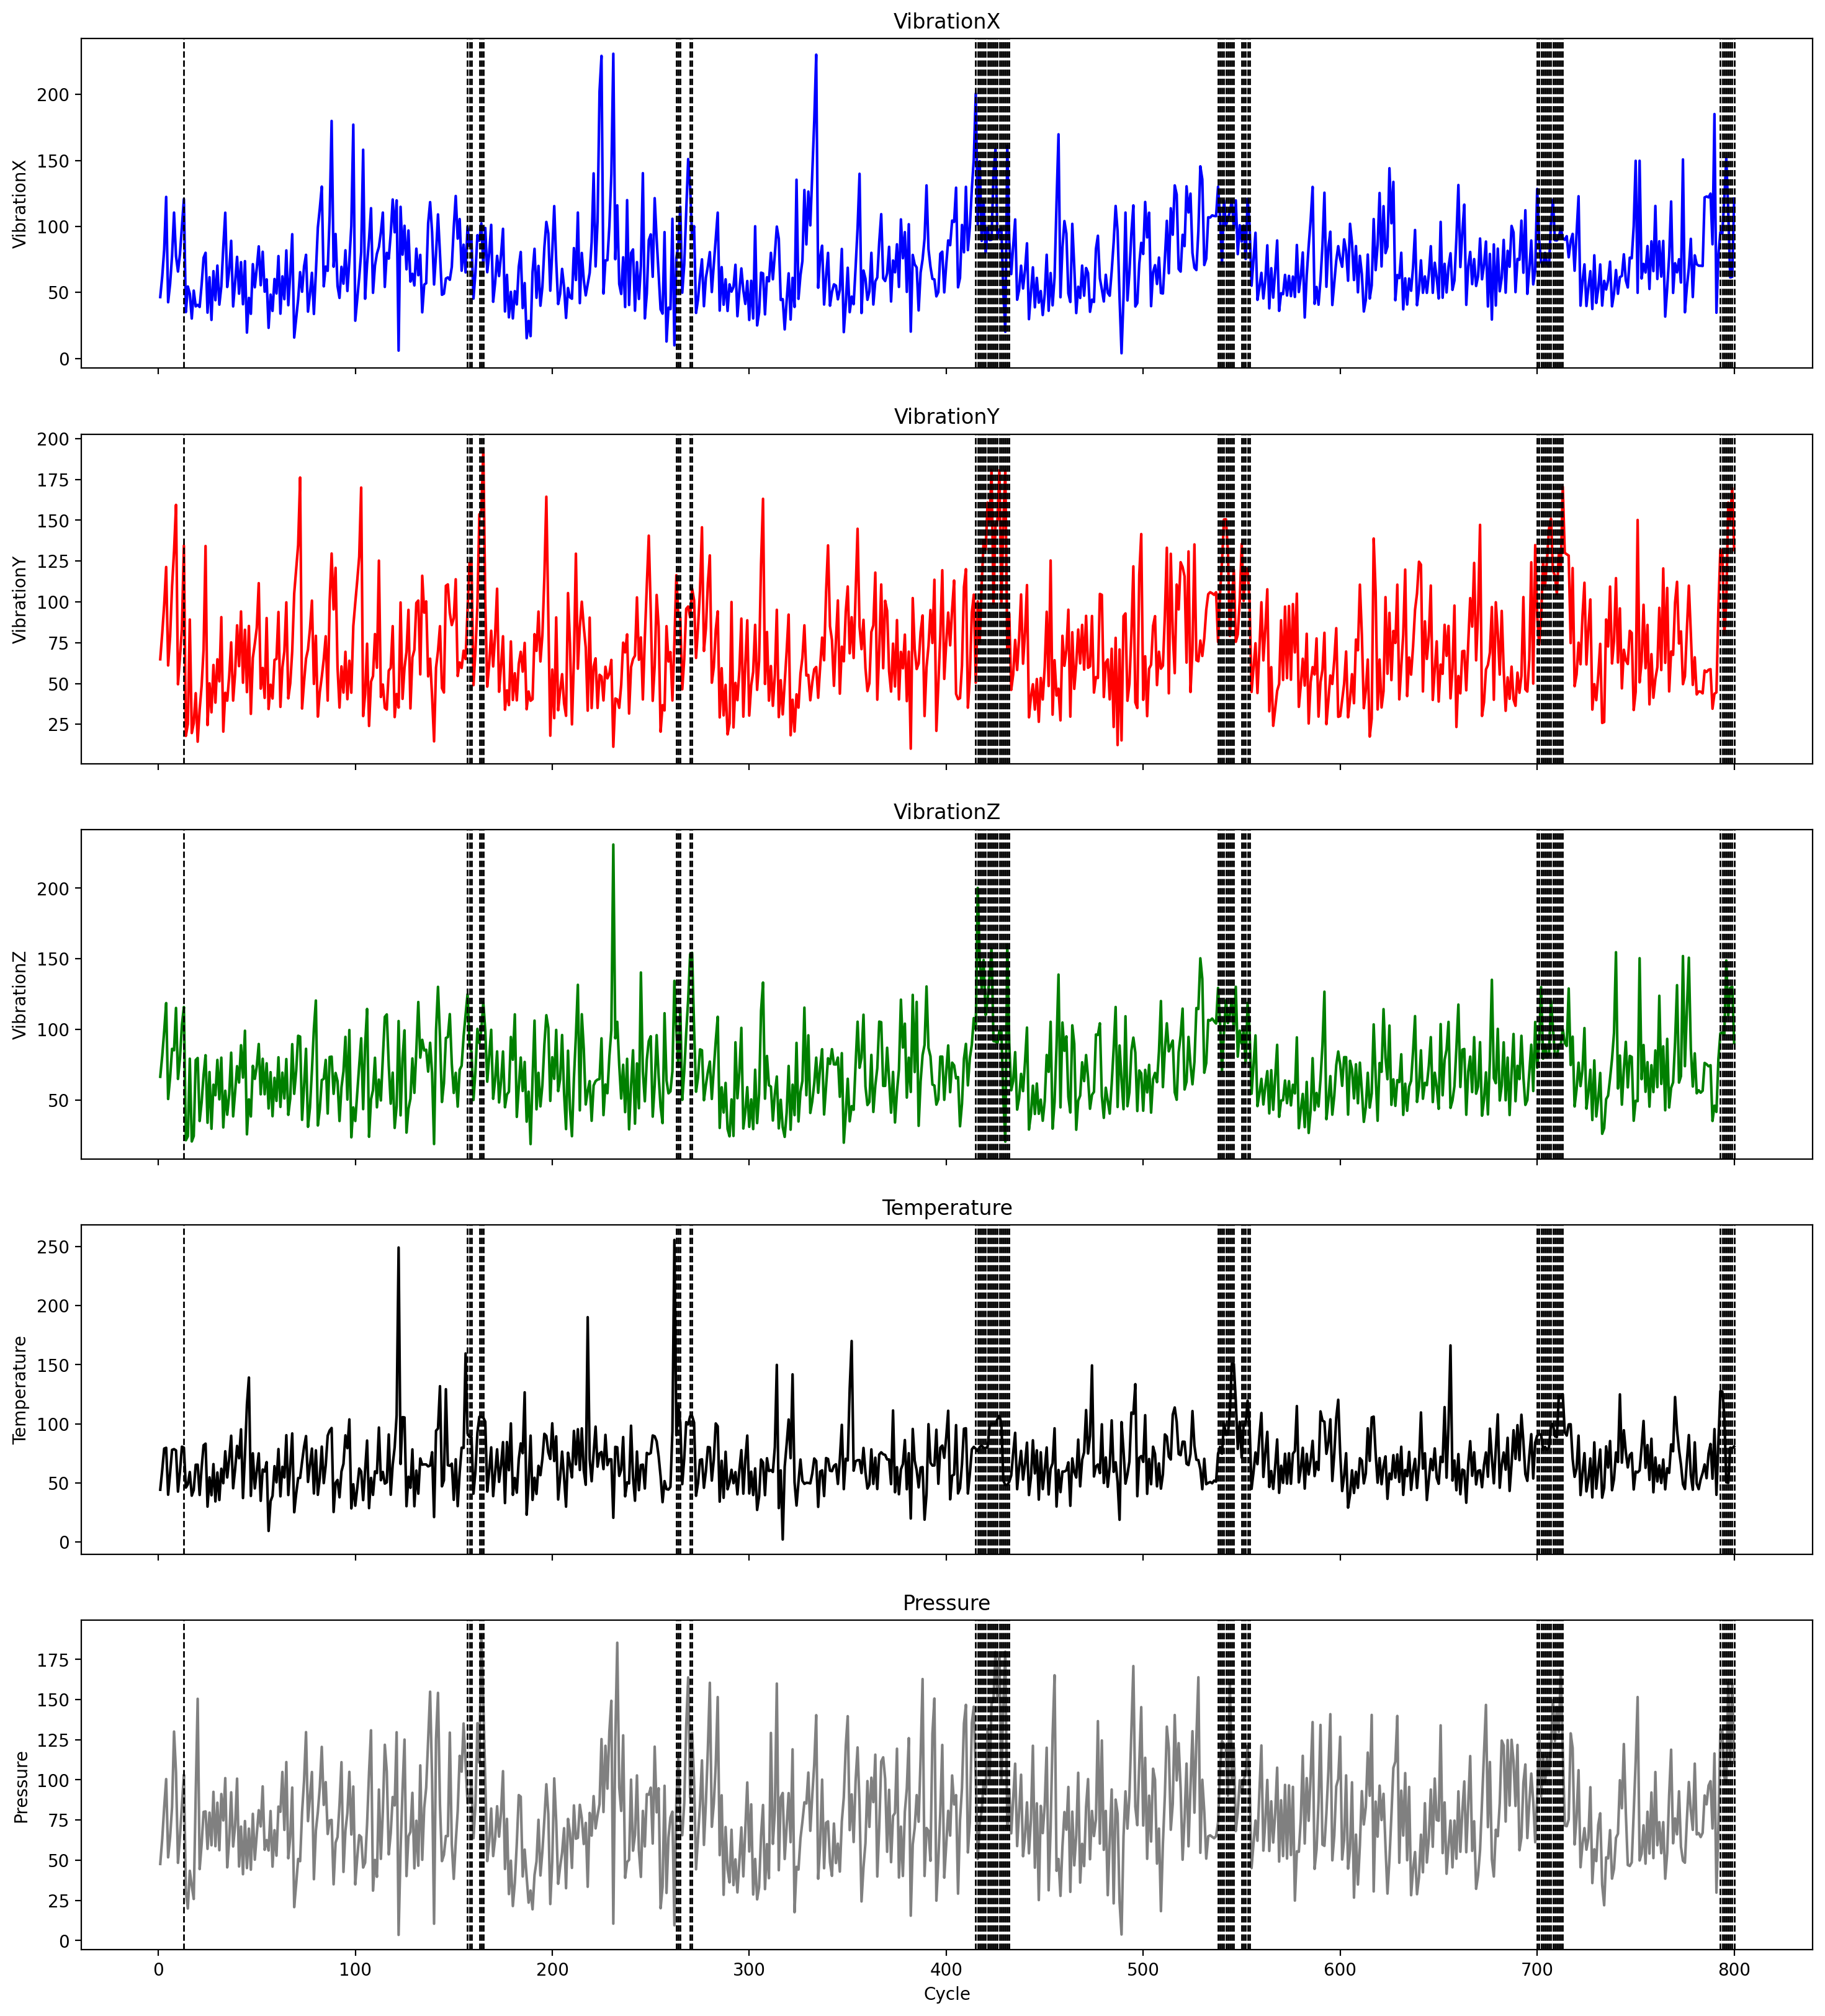

In [35]:
falhas = data[data['Fail'] == True]['Cycle']
fig, axs = plt.subplots(5, 1, figsize=(18, 20), sharex=True, dpi=200)
axs[0].plot(data['Cycle'], data['VibrationX'], label='VibrationX', color='blue')
axs[1].plot(data['Cycle'], data['VibrationY'], label='VibrationY', color='red')
axs[2].plot(data['Cycle'], data['VibrationZ'], label='VibrationZ', color='green')
axs[3].plot(data['Cycle'], data['Temperature'], label='VibrationX', color='black')
axs[4].plot(data['Cycle'], data['Pressure'], label='VibrationX', color='gray')



for ax in axs:
    for ciclo in falhas:
        ax.axvline(x=ciclo, color='k', linestyle='--', linewidth=1)

axs[0].set_ylabel('VibrationX')
axs[1].set_ylabel('VibrationY')
axs[2].set_ylabel('VibrationZ')
axs[3].set_ylabel('Temperature')
axs[4].set_ylabel('Pressure')
axs[4].set_xlabel('Cycle')


axs[0].set_title('VibrationX')
axs[1].set_title('VibrationY')
axs[2].set_title('VibrationZ')
axs[3].set_title('Temperature')
axs[4].set_title('Pressure')



plt.savefig('Vibration_Analysis.png', dpi=200, bbox_inches='tight')


From the figure above, we ca see that the fail occurs over all the cycles. But, there are some spots with a wigher density of failures, and that happens after cycle 400. It is hard to have some conclusions just by looking this graph. Qualitativelly, it is possible to observe in all parameters that there is a frequancy change when the fail occur. It is more clear in the Temperature measurementes. In adition to that, the Vibration in X direction have a peak, right when the fail batch start, after the cycle 400. It starts to increase the magnitude, untils the fail happens. Some similar behavior are present in the Y and Z direction. 

Now, applying the CWT to the parameters we will be able to see the changes in frequency during the cycles.

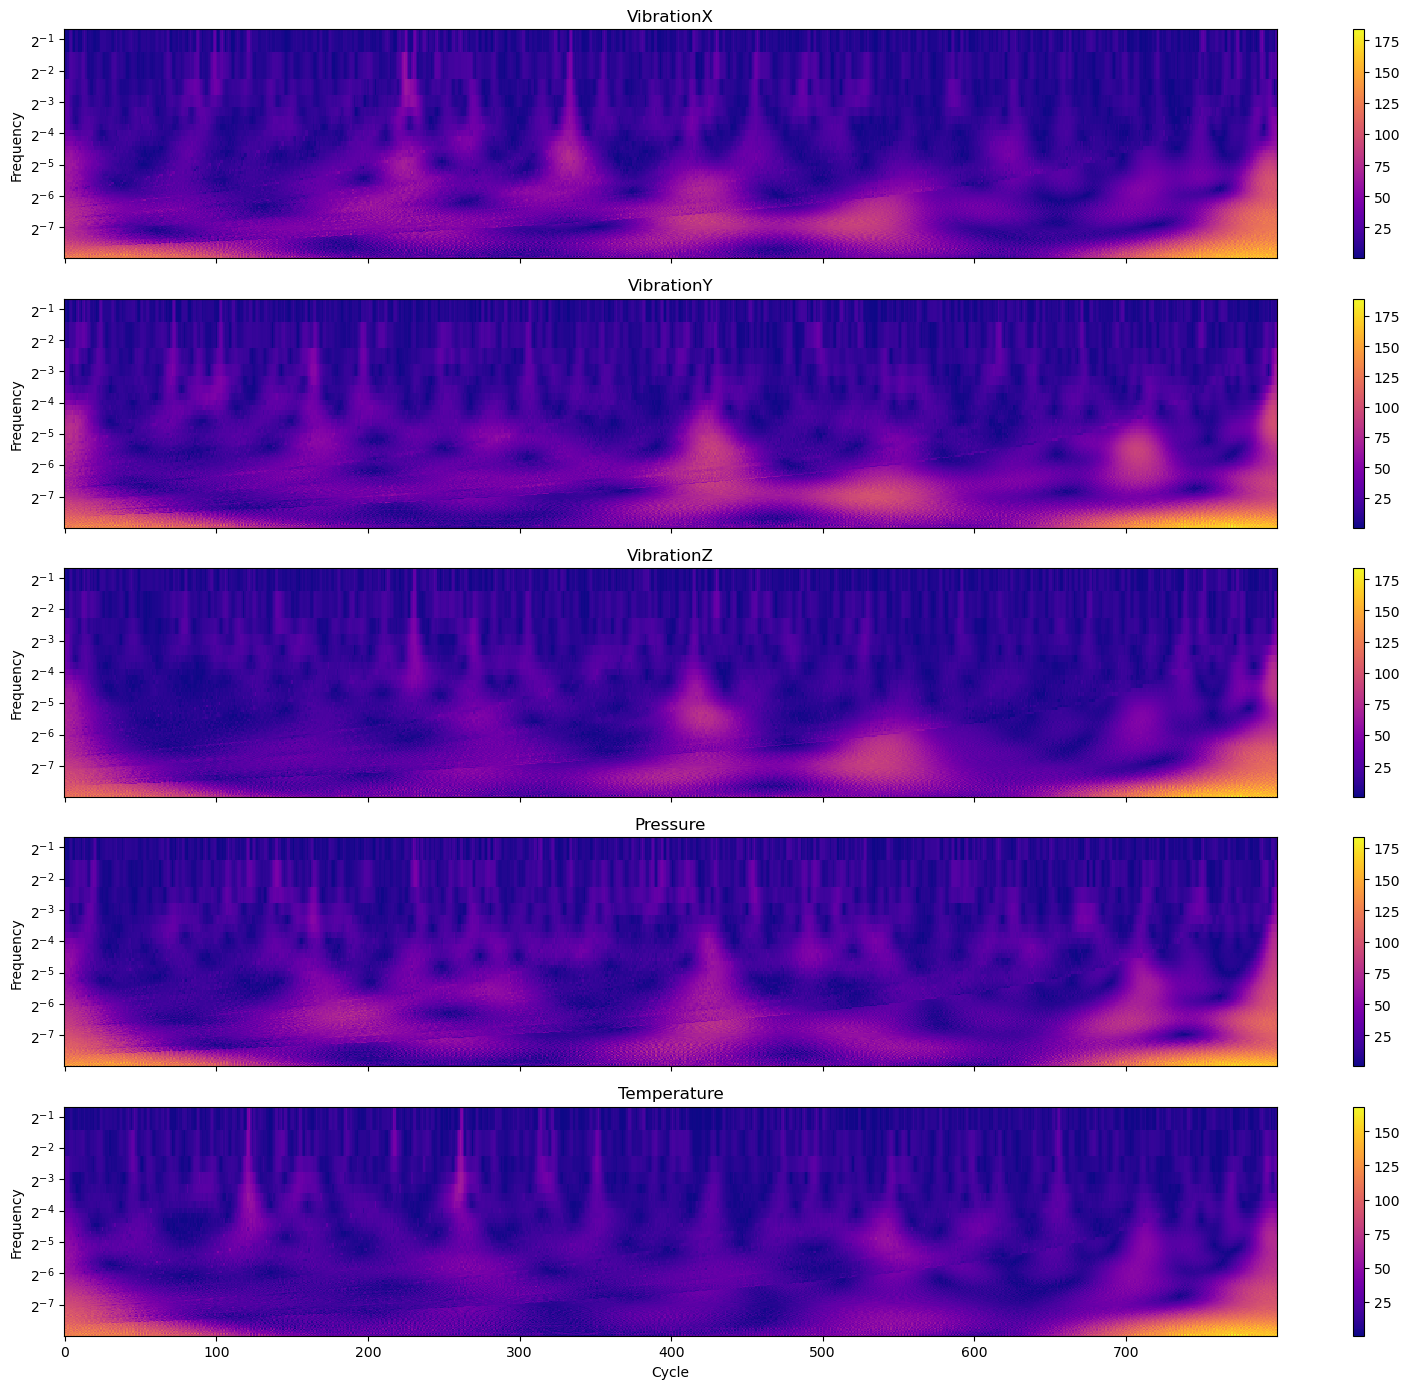

In [16]:
# Selecionar as componentes para análise
vibration_x = data['VibrationX'].values
vibration_y = data['VibrationY'].values
vibration_z = data['VibrationZ'].values
pressure = data['Pressure'].values
temperature = data['Temperature'].values

scales = np.arange(1, 128)

coef_x, freqs_x = pywt.cwt(vibration_x, scales, 'cmor1.5-0.5')
coef_y, freqs_y = pywt.cwt(vibration_y, scales, 'cmor1.5-0.5')
coef_z, freqs_z = pywt.cwt(vibration_z, scales, 'cmor1.5-0.5')
coef_pres, freqs_pres = pywt.cwt(pressure, scales, 'cmor1.5-0.5')
coef_temp, freqs_temp = pywt.cwt(temperature, scales, 'cmor1.5-0.5')

fig, axs = plt.subplots(5, 1, figsize=(16, 14), sharex=True)
cax1 = axs[0].pcolormesh(np.arange(len(vibration_x)), freqs_x, np.abs(coef_x), cmap='plasma')
fig.colorbar(cax1, ax=axs[0])
axs[0].set_title('VibrationX')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log', base=2)

cax2 = axs[1].pcolormesh(np.arange(len(vibration_y)), freqs_y, np.abs(coef_y), cmap='plasma')
fig.colorbar(cax2, ax=axs[1])
axs[1].set_title('VibrationY')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log', base=2)

cax3 = axs[2].pcolormesh(np.arange(len(vibration_z)), freqs_z, np.abs(coef_z), cmap='plasma')
fig.colorbar(cax3, ax=axs[2])
axs[2].set_title('VibrationZ')
axs[2].set_ylabel('Frequency')
axs[2].set_yscale('log', base=2)

cax4 = axs[3].pcolormesh(np.arange(len(pressure)), freqs_pres, np.abs(coef_pres), cmap='plasma')
fig.colorbar(cax4, ax=axs[3])
axs[3].set_title('Pressure')
axs[3].set_ylabel('Frequency')
axs[3].set_yscale('log', base=2)

cax5 = axs[4].pcolormesh(np.arange(len(temperature)), freqs_temp, np.abs(coef_temp), cmap='plasma')
fig.colorbar(cax5, ax=axs[4])
axs[4].set_title('Temperature')
axs[4].set_ylabel('Frequency')
axs[4].set_yscale('log', base=2)

axs[4].set_xlabel('Cycle')

plt.tight_layout()
plt.savefig('wavelet_Analysis.png', dpi=200, bbox_inches='tight')

In [117]:
%%jinja markdown

# Modelling

For training these models we’ll be doing the following steps:

* Split the data into training and test sets. (80/20 proportion)
* Apply oversampling method only to the data.
* Train the model using the balanced training set.
* Evaluate the model’s performance on the unchanged test set.

## Resampling the data

In order to overcome the unbalanced data, it will be two methods, the Synthetic Minority Oversampling Technique (SMOTE) and  the Adaptive Synthetic Sampling Approach for Imbalanced Learning (ADASYN).

But first, lets build a model with no oversampling. Let's use the Logistic regression model in this first scenario.


# Modelling

For training these models we’ll be doing the following steps:

* Split the data into training and test sets. (80/20 proportion)
* Apply oversampling method only to the data.
* Train the model using the balanced training set.
* Evaluate the model’s performance on the unchanged test set.

## Resampling the data

In order to overcome the unbalanced data, it will be two methods, the Synthetic Minority Oversampling Technique (SMOTE) and  the Adaptive Synthetic Sampling Approach for Imbalanced Learning (ADASYN).

But first, lets build a model with no oversampling. Let's use the Logistic regression model in this first scenario.

In [94]:
data['Fail'] = data['Fail'].astype(int)

In [95]:
X = data.drop(columns=['Cycle','Preset_1', 'Preset_2', 'Fail'])
y = data.drop(columns=['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency'])

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state=0)
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

In [110]:
model = LogisticRegression()

model.fit(X_train, y_train)
predictions = model.predict(X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [111]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

In [112]:
print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  15
False Positive(FP) =  48
True Negative(TN)  =  97
False Negative(FN) =  0


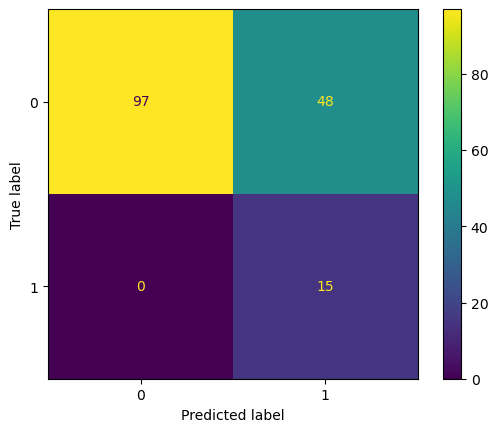

In [121]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [113]:
accuracy =  (TP + TN) / (TP + FP + TN + FN)

print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

Accuracy of the binary classifier = 0.700


We got an accuracy of 0.70. And from the confusion matrix, we can see a considerable number of false positive values.

Now lets use the SMOTE method to balance the dataset, and perform the traning and prediction of a Logistic regression model.

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


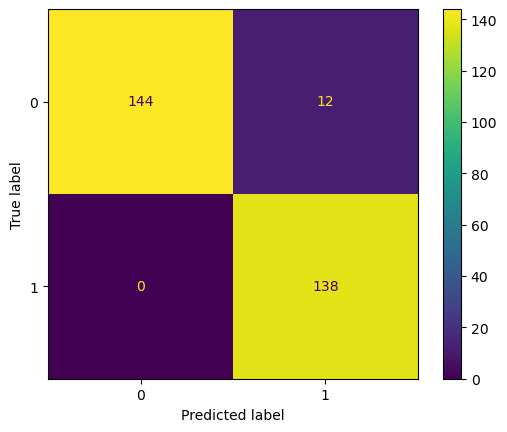

In [122]:
newDF = oversamplig_dataframe(data, 'Fail', method='SMOTE')
X = newDF.drop(columns=['Cycle','Preset_1', 'Preset_2', 'Fail'])
y = newDF.drop(columns=['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency'])

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state=0)
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

It is possible to note that balancing the dataset gives us a better prediction in this case.

### Variable importance (Explainability)

One way to evaluate the feature contribution is by using the SHAP (SHapley Additive exPlanations) values. They are a popular and powerful method for explaining the output of machine learning models. They are based on Shapley values, a concept from cooperative game theory that distributes "payouts" (in this case, predictions) among players (features) based on their contribution to the total payout.

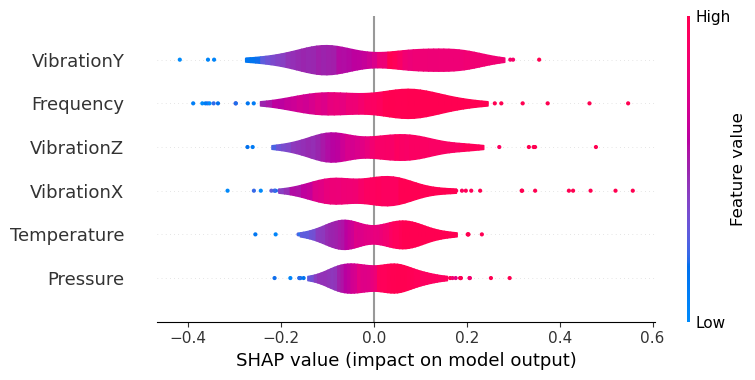

In [123]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, plot_type='violin', show=False)
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')

In [103]:
models = {}

# Logistic Regression
models['Logistic Regression'] = LogisticRegression()
# Support Vector Machines
models['Support Vector Machines'] = LinearSVC()
# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()
# Random Forest
models['Random Forest'] = RandomForestClassifier()
# Naive Bayes
models['Naive Bayes'] = GaussianNB()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [105]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model

,Accuracy,Precision,Recall
Logistic Regression,0.92500,0.400000,0.666667
Support Vector Machines,0.92500,0.400000,0.666667
Decision Trees,0.90000,0.133333,0.400000
Random Forest,0.93125,0.333333,0.833333
Naive Bayes,0.90625,0.533333,0.500000
K-Nearest Neighbor,0.92500,0.333333,0.714286


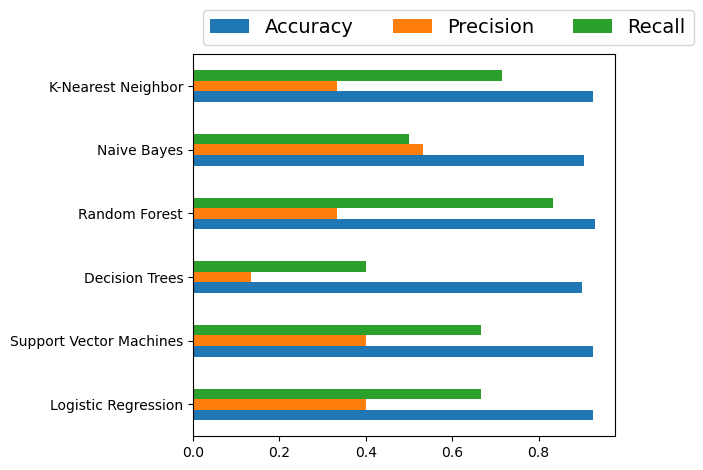

In [106]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')